<a href="https://colab.research.google.com/github/data-alch3m1st/PyTorch_tinkering/blob/main/effB2_FoodViz_tinkering_v003_effB2_only.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import torch
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from torchvision.models import efficientnet_b2, EfficientNet_B2_Weights
from torch import nn, optim
from torch.optim.lr_scheduler import StepLR
from torchinfo import summary

import os
from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from datetime import datetime

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from timeit import default_timer as timer
from tqdm import tqdm

import requests
import zipfile
from pathlib import Path
from matplotlib import pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [2]:
if torch.cuda.is_available():
    device = "cuda" # Use NVIDIA GPU (if available)
elif torch.backends.mps.is_available():
    device = "mps" # Use Apple Silicon GPU (if available)
else:
    device = "cpu" # Default to CPU if no GPU is available

print(device)

mps


In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Load the data from the drive:

train_dir = "./data/pizza_steak_sushi/train/"
test_dir = "./data/pizza_steak_sushi/test/"

### EfficientNet_B2 ###

In [4]:
# Load EfficientNet with B2 pretrained weights

# weights_eff = models.EfficientNet_B0_Weights.IMAGENET1K_V1

weights_eff = models.EfficientNet_B2_Weights.IMAGENET1K_V1
model_eff = models.efficientnet_b2(weights=weights_eff)
preprocess_eff = weights_eff.transforms()

Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-c35c1473.pth" to /Users/t4ng0_br4v0/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-c35c1473.pth
100%|████████████████████████████████████████| 35.2M/35.2M [00:01<00:00, 31.3MB/s]


In [6]:
# Use the preprocess transform for EfficientNet_B0 (preprocess_eff)

train_dataset = datasets.ImageFolder(
    root=train_dir
    , transform=preprocess_eff
)

test_dataset = datasets.ImageFolder(
    root=test_dir
    , transform=preprocess_eff
)

train_loader = DataLoader(
    dataset=train_dataset
    , batch_size=32
    , shuffle=True
    , num_workers=2
)

test_loader = DataLoader(
    dataset=test_dataset
    , batch_size=32
    , shuffle=False
    , num_workers=2
)

In [7]:
test_dataset.classes

['pizza', 'steak', 'sushi']

In [8]:
# EfficientNet_B2 model, class, device, criterion & optimizer instantiation

model = model_eff

# Number of classes (Pizza–Steak–Sushi)
num_classes = len(train_dataset.classes)  # should be 3

# Freeze all layers except classifier head
for param in model.parameters():
    param.requires_grad = False

# Replace the final classifier
# EfficientNet_B2 has model.classifier = Sequential(Dropout, Linear)
in_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(in_features, num_classes)

# Move model to device
model = model.to(device)

# Loss & optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=1e-3)

# Learning rate scheduler
scheduler = StepLR(optimizer, step_size=5, gamma=0.8)

In [9]:
# EfficientNet_B0 Training Loop *** With tqdm progress bar AND stored loss/acc for plotting in next cell;

# Lists to store metrics over epochs
train_losses = []
train_accuracies = []

# Since we already know it works well, just going with 20 epochs;)
epochs = 24

for epoch in tqdm(range(epochs)):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        correct += torch.sum(preds == labels).item()
        total += labels.size(0)

    # Compute metrics for this epoch
    train_loss = running_loss / total
    train_acc = correct / total * 100

    # Save metrics (so we can plot a loss/acc curve!)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    print(f"Epoch {epoch+1}/{epochs} | Loss: {train_loss:.4f} | Acc: {train_acc:.4f}%")

  4%|█▉                                            | 1/24 [00:28<11:00, 28.73s/it]

Epoch 1/24 | Loss: 1.0270 | Acc: 49.3333%


  8%|███▊                                          | 2/24 [00:44<07:41, 20.97s/it]

Epoch 2/24 | Loss: 0.8373 | Acc: 74.2222%


 12%|█████▊                                        | 3/24 [00:59<06:26, 18.41s/it]

Epoch 3/24 | Loss: 0.7422 | Acc: 82.2222%


 17%|███████▋                                      | 4/24 [01:15<05:46, 17.33s/it]

Epoch 4/24 | Loss: 0.6431 | Acc: 86.2222%


 21%|█████████▌                                    | 5/24 [01:30<05:12, 16.45s/it]

Epoch 5/24 | Loss: 0.5452 | Acc: 92.0000%


 25%|███████████▌                                  | 6/24 [01:47<04:58, 16.60s/it]

Epoch 6/24 | Loss: 0.5023 | Acc: 91.1111%


 29%|█████████████▍                                | 7/24 [02:02<04:36, 16.24s/it]

Epoch 7/24 | Loss: 0.4809 | Acc: 88.8889%


 33%|███████████████▎                              | 8/24 [02:17<04:11, 15.72s/it]

Epoch 8/24 | Loss: 0.4084 | Acc: 90.2222%


 38%|█████████████████▎                            | 9/24 [02:33<03:57, 15.83s/it]

Epoch 9/24 | Loss: 0.4335 | Acc: 88.0000%


 42%|██████████████████▊                          | 10/24 [02:48<03:40, 15.72s/it]

Epoch 10/24 | Loss: 0.4040 | Acc: 86.2222%


 46%|████████████████████▋                        | 11/24 [03:04<03:23, 15.64s/it]

Epoch 11/24 | Loss: 0.3471 | Acc: 95.5556%


 50%|██████████████████████▌                      | 12/24 [03:20<03:08, 15.72s/it]

Epoch 12/24 | Loss: 0.3821 | Acc: 93.7778%


 54%|████████████████████████▍                    | 13/24 [03:36<02:54, 15.88s/it]

Epoch 13/24 | Loss: 0.3351 | Acc: 93.7778%


 58%|██████████████████████████▎                  | 14/24 [03:51<02:36, 15.62s/it]

Epoch 14/24 | Loss: 0.2913 | Acc: 96.0000%


 62%|████████████████████████████▏                | 15/24 [04:06<02:18, 15.38s/it]

Epoch 15/24 | Loss: 0.3002 | Acc: 93.7778%


 67%|██████████████████████████████               | 16/24 [04:21<02:02, 15.31s/it]

Epoch 16/24 | Loss: 0.3162 | Acc: 92.0000%


 71%|███████████████████████████████▉             | 17/24 [04:36<01:46, 15.18s/it]

Epoch 17/24 | Loss: 0.2554 | Acc: 96.4444%


 75%|█████████████████████████████████▊           | 18/24 [04:50<01:29, 15.00s/it]

Epoch 18/24 | Loss: 0.2943 | Acc: 96.0000%


 79%|███████████████████████████████████▋         | 19/24 [05:05<01:14, 14.95s/it]

Epoch 19/24 | Loss: 0.2526 | Acc: 96.8889%


 83%|█████████████████████████████████████▌       | 20/24 [05:20<00:59, 14.85s/it]

Epoch 20/24 | Loss: 0.2736 | Acc: 94.2222%


 88%|███████████████████████████████████████▍     | 21/24 [05:34<00:44, 14.79s/it]

Epoch 21/24 | Loss: 0.2666 | Acc: 94.6667%


 92%|█████████████████████████████████████████▎   | 22/24 [05:49<00:29, 14.71s/it]

Epoch 22/24 | Loss: 0.2165 | Acc: 97.3333%


 96%|███████████████████████████████████████████▏ | 23/24 [06:04<00:14, 14.71s/it]

Epoch 23/24 | Loss: 0.2417 | Acc: 94.6667%


100%|█████████████████████████████████████████████| 24/24 [06:18<00:00, 15.78s/it]

Epoch 24/24 | Loss: 0.2199 | Acc: 96.8889%


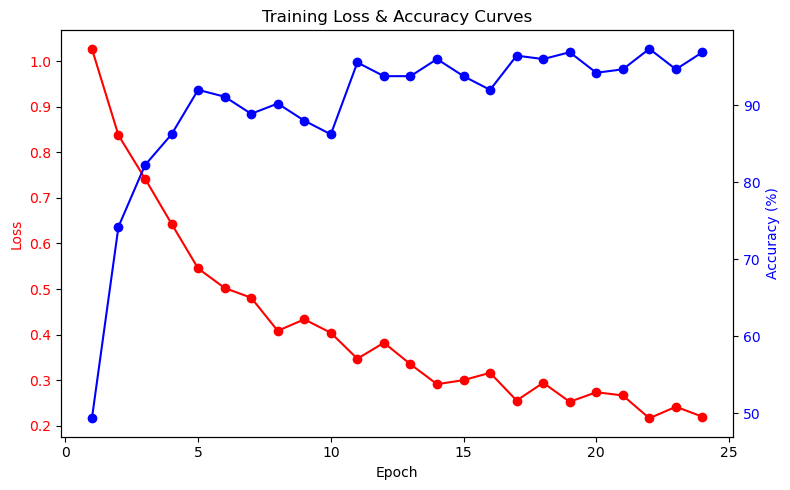

In [10]:
# --------------------------
# Plot Loss & Accuracy
# --------------------------
fig, ax1 = plt.subplots(figsize=(8, 5))

# Plot loss on left y-axis
ax1.plot(range(1, epochs+1), train_losses, color='red', marker='o', label='Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color='red')
ax1.tick_params(axis='y', labelcolor='red')

# Create a second y-axis for accuracy
ax2 = ax1.twinx()
ax2.plot(range(1, epochs+1), train_accuracies, color='blue', marker='o', label='Accuracy')
ax2.set_ylabel('Accuracy (%)', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

# Title and layout
plt.title('Training Loss & Accuracy Curves')
fig.tight_layout()
plt.show();

In [11]:
# Running Test Loop on EfficientNet

model.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        correct += torch.sum(preds == labels).item()
        total += labels.size(0)

test_acc = correct / total * 100
print(f"Test Accuracy: {test_acc:.4f}%")

Test Accuracy: 89.3333%


In [12]:
model.classifier

Sequential(
  (0): Dropout(p=0.3, inplace=True)
  (1): Linear(in_features=1408, out_features=3, bias=True)
)

In [13]:
train_loss, train_acc

(0.21992775069342718, 96.88888888888889)

***Save trained model***

In [14]:
# Set up a 'saved_models' directory (if it doesnt already exist):
from datetime import datetime

save_dir = "./saved_models/"
os.makedirs(save_dir, exist_ok=True)  # creates it if it doesn't exist

# Add the current date to the filename
current_date = datetime.now().strftime("%Y%m%d")
model_save_path = os.path.join(save_dir, f"efficientnet_b2_pizza_steak_sushi_{current_date}.pth")

In [15]:
# Save the trained model to .pth

# Save only the parameters
torch.save(model.state_dict(), model_save_path)
print(f"Model state_dict saved to: {model_save_path}")

Model state_dict saved to: ./saved_models/efficientnet_b2_pizza_steak_sushi_20251022.pth


In [16]:
import os
from PIL import Image
import torch
from torchvision import models

# Folder containing unseen images
folder_path = "./data/unseen_pza_stk_ssh/"

# Make a list of image files
image_files = [f for f in os.listdir(folder_path) if f.lower().endswith((".jpg", ".jpeg", ".png"))]

# Preprocessing used for EfficientNet_B0
weights = models.EfficientNet_B0_Weights.IMAGENET1K_V1
preprocess = weights.transforms()

# Class names (same as your dataset)
class_names = ["pizza", "steak", "sushi"]

# Ensure the model is in evaluation mode
model.eval()
model = model.to(device)

In [17]:
predicted_labels = []
for img_name in image_files:
    img_path = os.path.join(folder_path, img_name)
    image = Image.open(img_path).convert("RGB")
    input_tensor = preprocess(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(input_tensor)
        probabilities = torch.nn.functional.softmax(output[0], dim=0)
        predicted_class = class_names[probabilities.argmax()]
        predicted_labels.append(predicted_class)

    print(f"{img_name} → Predicted: {predicted_class}")

sushi_003.jpeg → Predicted: sushi
sushi_002.jpeg → Predicted: sushi
pizza_001.jpeg → Predicted: pizza
steak_001.jpeg → Predicted: pizza
steak_003.jpeg → Predicted: steak
steak_002.jpeg → Predicted: steak
sushi_001.jpeg → Predicted: sushi
pizza_002.jpeg → Predicted: pizza
pizza_003.jpeg → Predicted: pizza


In [18]:
# Extract true labels from filenames
true_labels = [f.split("_")[0] for f in image_files]
print(true_labels)

['sushi', 'sushi', 'pizza', 'steak', 'steak', 'steak', 'sushi', 'pizza', 'pizza']


In [19]:
from sklearn.metrics import classification_report, confusion_matrix

print("Classification Report:\n")
print(classification_report(true_labels, predicted_labels))

print("Confusion Matrix:\n")
print(confusion_matrix(true_labels, predicted_labels))

Classification Report:

              precision    recall  f1-score   support

       pizza       0.75      1.00      0.86         3
       steak       1.00      0.67      0.80         3
       sushi       1.00      1.00      1.00         3

    accuracy                           0.89         9
   macro avg       0.92      0.89      0.89         9
weighted avg       0.92      0.89      0.89         9

Confusion Matrix:

[[3 0 0]
 [1 2 0]
 [0 0 3]]


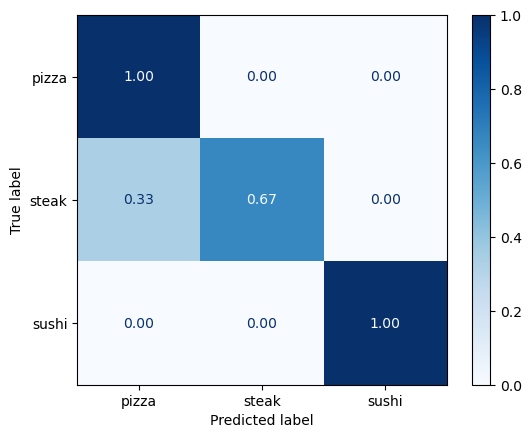

In [20]:
# ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay.from_predictions(
    true_labels, predicted_labels
    , normalize="true", cmap="Blues"
)

# replace default annotations with two-decimal strings
for txt in plt.gca().texts: txt.set_text(f"{float(txt.get_text()):.2f}")
plt.show();

In [22]:
import os
from PIL import Image
import torch
from torchvision import models
from matplotlib import pyplot as plt

In [23]:
# Updated predix function w/ probabilities displayed;

def show_image_prediction(img_path):
    # Load and preprocess
    image = Image.open(img_path).convert("RGB")
    input_tensor = preprocess(image).unsqueeze(0).to(device)

    # Predict
    with torch.no_grad():
        output = model(input_tensor)
        probabilities = torch.nn.functional.softmax(output[0], dim=0)
        pred_idx = probabilities.argmax()
        pred_class = class_names[pred_idx]
        pred_prob = probabilities[pred_idx].item() * 100

    # Display image with prediction
    plt.figure(figsize=(5, 5))
    plt.imshow(image)
    plt.axis("off")
    plt.title(f"Predicted: {pred_class} ({pred_prob:.2f}%)", fontsize=14, color='green')
    plt.show()

    # Print probability distribution below the image
    print("Class probabilities:")
    for i, cls in enumerate(class_names):
        prob = probabilities[i].item() * 100
        mark = "True" if i == pred_idx else "False"
        print(f"{mark} {cls:10s}: {prob:.4f}%")

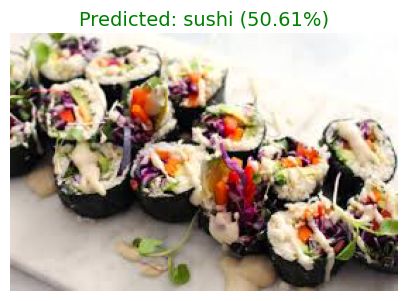

Class probabilities:
False pizza     : 28.8136%
False steak     : 20.5788%
True sushi     : 50.6076%


In [24]:
show_image_prediction(os.path.join(folder_path, image_files[0]))

In [ ]:
show_image_prediction(os.path.join(folder_path, image_files[0]))

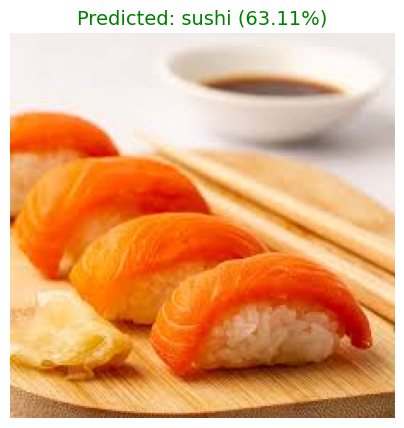

Class probabilities:
False pizza     : 15.8215%
False steak     : 21.0709%
True sushi     : 63.1075%


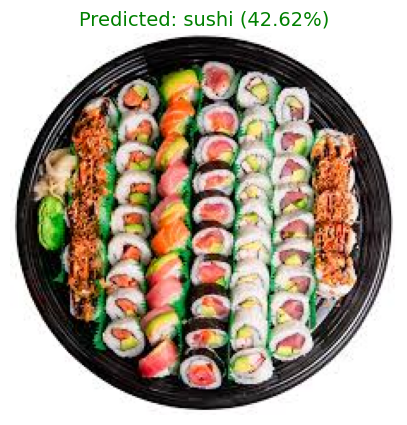

Class probabilities:
False pizza     : 32.7738%
False steak     : 24.6065%
True sushi     : 42.6198%


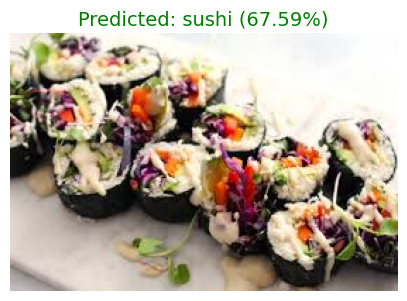

Class probabilities:
False pizza     : 22.4093%
False steak     : 10.0040%
True sushi     : 67.5867%


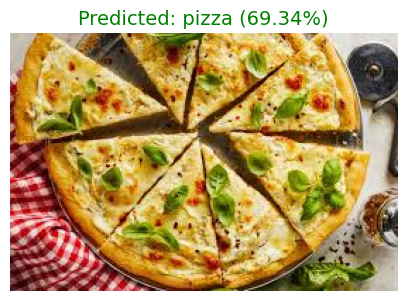

Class probabilities:
True pizza     : 69.3440%
False steak     : 9.5566%
False sushi     : 21.0994%


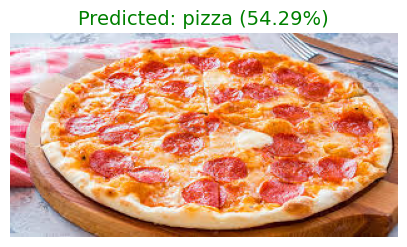

Class probabilities:
True pizza     : 54.2942%
False steak     : 17.7956%
False sushi     : 27.9101%


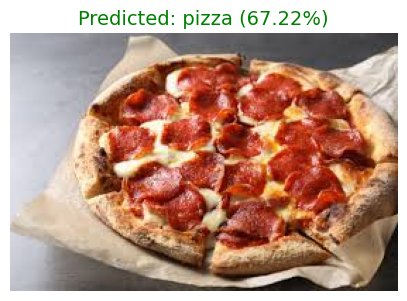

Class probabilities:
True pizza     : 67.2163%
False steak     : 15.7672%
False sushi     : 17.0165%


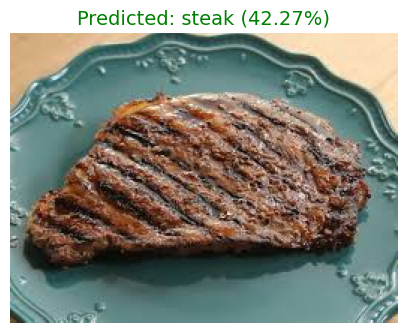

Class probabilities:
False pizza     : 24.9956%
True steak     : 42.2668%
False sushi     : 32.7376%


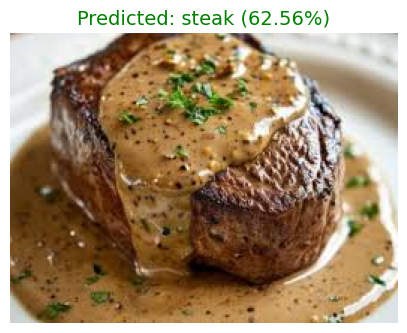

Class probabilities:
False pizza     : 22.5451%
True steak     : 62.5598%
False sushi     : 14.8951%


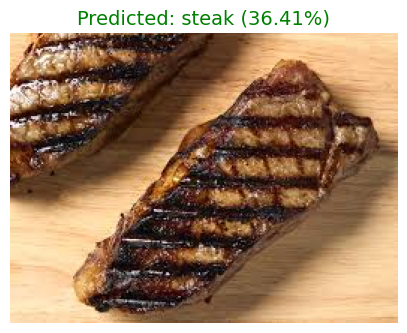

Class probabilities:
False pizza     : 28.5439%
True steak     : 36.4073%
False sushi     : 35.0488%


In [30]:
for img_name in image_files:
    img_path = os.path.join(folder_path, img_name)
    show_image_prediction(img_path)

In [31]:
# get one batch
images, labels = next(iter(train_loader))

print("images.shape:", images.shape)   # e.g. torch.Size([32, 3, H, W])
print("labels.shape:", labels.shape)   # e.g. torch.Size([32])

images.shape: torch.Size([32, 3, 288, 288])
labels.shape: torch.Size([32])


In [32]:
images, labels = next(iter(train_loader))
i = torch.randint(len(images), (1,)).item()   # random index in the batch
print(f"sample index: {i}")
print("single image shape:", images[i].shape)  # e.g. torch.Size([3, H, W])
print("single label:", labels[i].item())

sample index: 25
single image shape: torch.Size([3, 288, 288])
single label: 2


In [33]:
import random
idx = random.randrange(len(train_dataset))
img, label = train_dataset[idx]
print("dataset sample shape:", img.shape)   # e.g. torch.Size([3, H, W])
print("label:", label)

dataset sample shape: torch.Size([3, 288, 288])
label: 0


### Observations ###

- In comparing EfficientNetB2 vs EfficientNetB0 performance, the B2 was only fractionally better in test data - BUT - when looking at the probabilities in the labels, the B0 probabilities were much better on correct labeling (hence, it could be argued that B0 - all things being equal - was *more* correct.)

In [ ]:
"""
You cannot directly use the Google Drive folder link as a file path in Colab. After you mount your Google Drive, you can navigate to the folder in the file browser on the left-hand side of Colab to find its path. It will likely be something like /content/drive/My Drive/Your Folder Name.

Once you have the correct path, you can use it to load your data.

/content/drive/MyDrive/_Δατα_sсιεисэ/PyTorch_experimenting/data/pizza_steak_sushi
"""